In [1]:
import numpy as np
import h5py
import matplotlib
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import os


# Load .npy file using numpy
input_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test/z1_4_33-x01.04-y00.82_noTDS_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc.hdf5"
output_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test/z1_4_33-x01.04-y00.82_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc.hdf5"
label_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test_Z_map/z1_4_33-x01.04-y00.82.npy"

tempNoT = h5py.File(input_dir, 'r')
input_data = tempNoT['array'][:]  # Shape (batch_size, channels, height, width)

tempTDS = h5py.File(input_dir, 'r')
output_data = tempTDS['array'][:]  # Shape (batch_size, channels, height, width)

label_data = np.load(label_dir)  # Shape (batch_size, label_dim)

# Convert numpy arrays to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)
label_tensor = torch.tensor(label_data, dtype=torch.float32)

# Check shapes
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Output tensor shape: {output_tensor.shape}")
print(f"Label tensor shape: {label_tensor.shape}")


Input tensor shape: torch.Size([59, 59, 64, 64])
Output tensor shape: torch.Size([59, 59, 64, 64])
Label tensor shape: torch.Size([59, 59])


In [ ]:
# Check shapes
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Output tensor shape: {output_tensor.shape}")
print(f"Label tensor shape: {label_tensor.shape}")

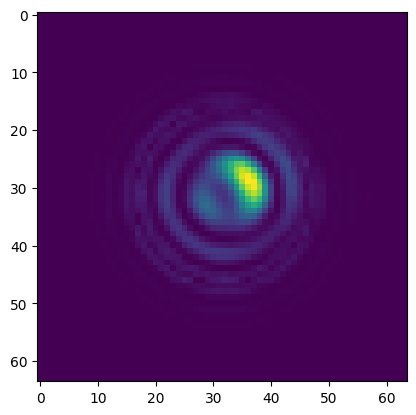

In [40]:
plt.imshow(input_tensor[5,5,:,:])

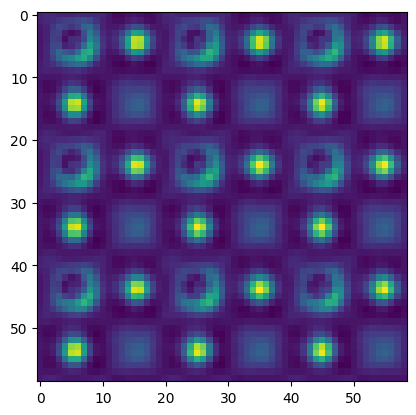

In [32]:
plt.imshow(input_tensor[:,:,32,32])

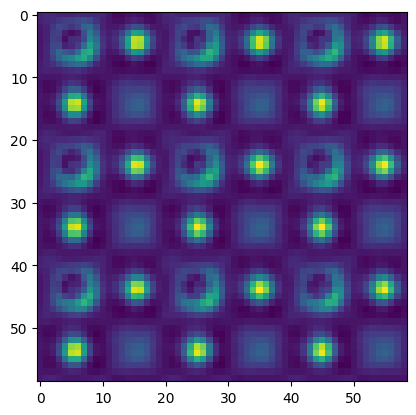

In [33]:
plt.imshow(output_tensor[:,:,32,32])

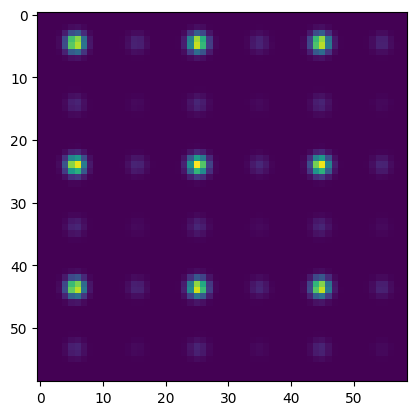

In [34]:
plt.imshow(label_tensor)

In [27]:
class IntoInelastic2D(nn.Module):
    def __init__(self):
        super(IntoInelastic2D, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(2, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder
        self.dec3 = self.upconv_block(512 + 256, 256)
        self.dec2 = self.upconv_block(256 + 128, 128)
        self.dec1 = self.upconv_block(128 + 64, 64)

        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """A convolutional block with two Conv2D layers and ReLU activations."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        """An upsampling block with transposed convolution and a conv block."""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc3, 2))

        # Decoder
        dec3 = self.dec3(torch.cat((self.upsample(bottleneck, enc3), enc3), dim=1))
        dec2 = self.dec2(torch.cat((self.upsample(dec3, enc2), enc2), dim=1))
        dec1 = self.dec1(torch.cat((self.upsample(dec2, enc1), enc1), dim=1))

        # Final output
        final_output = self.final(dec1)

        # Ensure output size matches target (64x64)
        final_output = F.interpolate(final_output, size=(64, 64), mode='bilinear', align_corners=False)
        return final_output



    def upsample(self, x, target):
        """Upsample `x` to the size of `target`."""
        return F.interpolate(x, size=target.shape[2:], mode='bilinear', align_corners=True)

In [28]:
import torch
from torch.utils.data import DataLoader, Dataset

# Example Dataset Class
class CustomDataset(Dataset):
    def __init__(self, input_data, label_data, output_data):
        self.input_data = input_data
        self.label_data = label_data
        self.output_data = output_data

    def __len__(self):
        return self.input_data.shape[0] * self.input_data.shape[1]

    def __getitem__(self, idx):
        # Find correct index in 2D structure
        i = idx // self.input_data.shape[1]
        j = idx % self.input_data.shape[1]

        # Extract 64x64 image, label, and target
        image = self.input_data[i, j]      # Shape (64, 64)
        label = self.label_data[i, j]     # Shape ()
        target = self.output_data[i, j]   # Shape (64, 64)

        # Combine image and label into 2-channel input
        combined_input = torch.stack([image, torch.full_like(image, label)], dim=0)
        return combined_input, target

# # Load Data
# input_data = torch.randn(59, 59, 64, 64)  # Replace with actual data
# label_data = torch.randn(59, 59)         # Replace with actual labels
# output_data = torch.randn(59, 59, 64, 64)  # Replace with target output

# Create Dataset and DataLoader
dataset = CustomDataset(input_tensor, label_tensor, output_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)



Using device: cuda


Epoch [1/50]:   0%|          | 0/348 [00:00<?, ?it/s, loss=0.00104]

Epoch [1/50]: 100%|██████████| 348/348 [00:10<00:00, 34.31it/s, loss=4.35e-7]


Epoch [1], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [2/50]: 100%|██████████| 348/348 [00:09<00:00, 34.89it/s, loss=1.25e-7]


Epoch [2], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [3/50]: 100%|██████████| 348/348 [00:10<00:00, 34.64it/s, loss=1.47e-6]


Epoch [3], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [4/50]: 100%|██████████| 348/348 [00:10<00:00, 34.75it/s, loss=7.42e-8]


Epoch [4], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [5/50]: 100%|██████████| 348/348 [00:10<00:00, 34.60it/s, loss=1.41e-7]


Epoch [5], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [6/50]: 100%|██████████| 348/348 [00:10<00:00, 34.27it/s, loss=6.86e-8]


Epoch [6], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [7/50]: 100%|██████████| 348/348 [00:10<00:00, 33.68it/s, loss=1.05e-6]


Epoch [7], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [8/50]: 100%|██████████| 348/348 [00:10<00:00, 32.02it/s, loss=6.58e-8]


Epoch [8], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [9/50]: 100%|██████████| 348/348 [00:10<00:00, 31.91it/s, loss=7.06e-8]


Epoch [9], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [10/50]: 100%|██████████| 348/348 [00:11<00:00, 31.45it/s, loss=6.58e-8]


Epoch [10], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [11/50]: 100%|██████████| 348/348 [00:11<00:00, 31.61it/s, loss=6.32e-8]


Epoch [11], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [12/50]: 100%|██████████| 348/348 [00:10<00:00, 32.21it/s, loss=6.73e-8]


Epoch [12], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [13/50]: 100%|██████████| 348/348 [00:10<00:00, 31.94it/s, loss=7.56e-8]


Epoch [13], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [14/50]: 100%|██████████| 348/348 [00:10<00:00, 32.11it/s, loss=7.08e-8]


Epoch [14], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [15/50]: 100%|██████████| 348/348 [00:10<00:00, 32.10it/s, loss=6.86e-8]


Epoch [15], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [16/50]: 100%|██████████| 348/348 [00:10<00:00, 32.00it/s, loss=7e-8]   


Epoch [16], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [17/50]: 100%|██████████| 348/348 [00:10<00:00, 32.14it/s, loss=7.02e-8]


Epoch [17], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [18/50]: 100%|██████████| 348/348 [00:10<00:00, 31.84it/s, loss=5.93e-8]


Epoch [18], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [19/50]: 100%|██████████| 348/348 [00:10<00:00, 31.74it/s, loss=6.95e-8]


Epoch [19], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [20/50]: 100%|██████████| 348/348 [00:10<00:00, 31.89it/s, loss=6.27e-8]


Epoch [20], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [21/50]: 100%|██████████| 348/348 [00:10<00:00, 33.14it/s, loss=6.65e-8]


Epoch [21], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [22/50]: 100%|██████████| 348/348 [00:10<00:00, 33.23it/s, loss=6.49e-8]


Epoch [22], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [23/50]: 100%|██████████| 348/348 [00:10<00:00, 33.01it/s, loss=7.11e-8]


Epoch [23], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [24/50]: 100%|██████████| 348/348 [00:10<00:00, 33.13it/s, loss=6.03e-8]


Epoch [24], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [25/50]: 100%|██████████| 348/348 [00:10<00:00, 32.93it/s, loss=5.92e-8]


Epoch [25], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [26/50]: 100%|██████████| 348/348 [00:10<00:00, 32.99it/s, loss=6.34e-8]


Epoch [26], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [27/50]: 100%|██████████| 348/348 [00:10<00:00, 32.95it/s, loss=6.02e-8]


Epoch [27], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [28/50]: 100%|██████████| 348/348 [00:10<00:00, 32.90it/s, loss=6.31e-8]


Epoch [28], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [29/50]: 100%|██████████| 348/348 [00:10<00:00, 32.86it/s, loss=7.76e-8]


Epoch [29], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [30/50]: 100%|██████████| 348/348 [00:10<00:00, 33.41it/s, loss=7.38e-8]


Epoch [30], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [31/50]: 100%|██████████| 348/348 [00:10<00:00, 32.05it/s, loss=6.6e-8] 


Epoch [31], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [32/50]: 100%|██████████| 348/348 [00:11<00:00, 30.61it/s, loss=7.23e-8]


Epoch [32], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [33/50]: 100%|██████████| 348/348 [00:11<00:00, 30.59it/s, loss=7.27e-8]


Epoch [33], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [34/50]: 100%|██████████| 348/348 [00:10<00:00, 32.11it/s, loss=6.72e-8]


Epoch [34], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [35/50]: 100%|██████████| 348/348 [00:11<00:00, 31.35it/s, loss=5.89e-8]


Epoch [35], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [36/50]: 100%|██████████| 348/348 [00:11<00:00, 30.79it/s, loss=7.34e-8]


Epoch [36], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [37/50]: 100%|██████████| 348/348 [00:11<00:00, 31.49it/s, loss=5.8e-8] 


Epoch [37], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [38/50]: 100%|██████████| 348/348 [00:10<00:00, 32.25it/s, loss=6.02e-8]


Epoch [38], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [39/50]: 100%|██████████| 348/348 [00:10<00:00, 32.08it/s, loss=6.1e-8] 


Epoch [39], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [40/50]: 100%|██████████| 348/348 [00:10<00:00, 32.05it/s, loss=6.49e-8]


Epoch [40], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [41/50]: 100%|██████████| 348/348 [00:10<00:00, 31.84it/s, loss=6.26e-8]


Epoch [41], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [42/50]: 100%|██████████| 348/348 [00:10<00:00, 33.61it/s, loss=6.45e-8]


Epoch [42], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [43/50]: 100%|██████████| 348/348 [00:10<00:00, 32.51it/s, loss=5.85e-8]


Epoch [43], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [44/50]: 100%|██████████| 348/348 [00:11<00:00, 31.30it/s, loss=6.32e-8]


Epoch [44], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [45/50]: 100%|██████████| 348/348 [00:10<00:00, 32.20it/s, loss=6.47e-8]


Epoch [45], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [46/50]: 100%|██████████| 348/348 [00:10<00:00, 31.93it/s, loss=5.39e-8]


Epoch [46], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [47/50]: 100%|██████████| 348/348 [00:11<00:00, 31.40it/s, loss=6.74e-8]


Epoch [47], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [48/50]: 100%|██████████| 348/348 [00:10<00:00, 32.23it/s, loss=5.21e-8]


Epoch [48], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [49/50]: 100%|██████████| 348/348 [00:11<00:00, 30.91it/s, loss=3.7e-8] 


Epoch [49], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [50/50]: 100%|██████████| 348/348 [00:11<00:00, 31.44it/s, loss=3.1e-8] 


Epoch [50], Train Loss: 0.0000, Test Loss: 0.0000


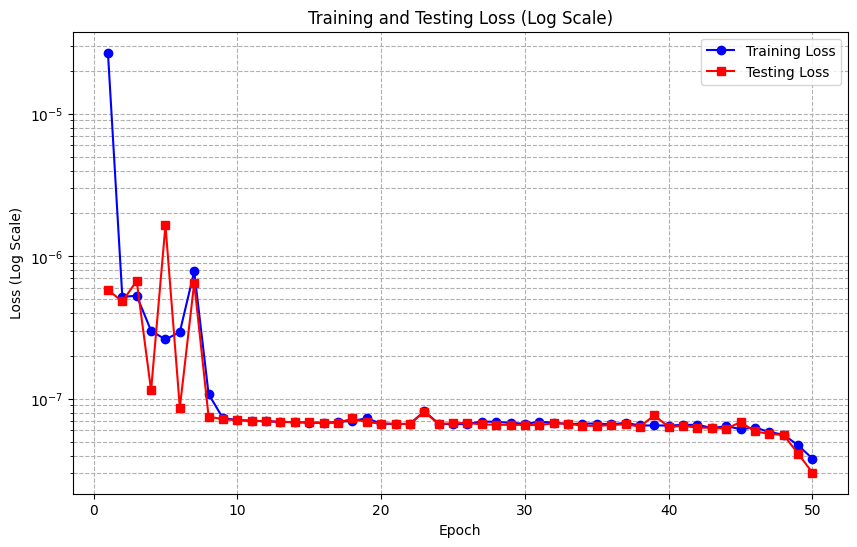

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Model, Loss, and Optimizer
model = IntoInelastic2D().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Split Dataset into Training and Testing Sets (80:20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Track Training and Testing Loss
train_losses = []
test_losses = []

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    
    # Train Loop with Progress Bar
    loop = tqdm(train_loader, total=len(train_loader), leave=True)
    for combined_input, target in loop:
        # Move data to GPU
        combined_input, target = combined_input.to(device), target.to(device)

        optimizer.zero_grad()

        # Forward pass
        prediction = model(combined_input)
        target = target.unsqueeze(1)  # Correct Target Shape

        # Calculate loss
        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()

        # Update Progress Bar
        running_train_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Average Training Loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on Test Set
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for combined_input, target in test_loader:
            combined_input, target = combined_input.to(device), target.to(device)
            prediction = model(combined_input)
            target = target.unsqueeze(1)  # Correct Target Shape

            # Calculate Test Loss
            test_loss = criterion(prediction, target)
            running_test_loss += test_loss.item()

    # Average Test Loss
    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch [{epoch+1}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot Training and Testing Loss Curves with Log Scale
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o', color='b')
plt.plot(range(1, num_epochs+1), test_losses, label='Testing Loss', marker='s', color='r')

plt.title("Training and Testing Loss (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("Loss (Log Scale)")
plt.yscale('log')  # Apply log scale to y-axis
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()



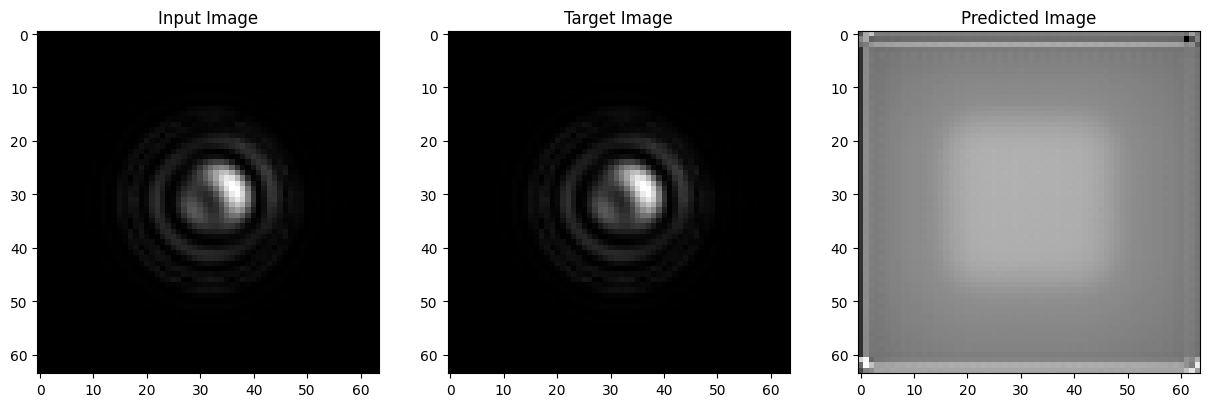

In [43]:
# Switch model to evaluation mode
model.eval()

# Select specific input sample
sample_input = input_tensor[5, 5, :, :].unsqueeze(0).unsqueeze(0).to(device)  # Shape: (1, 1, 64, 64)
sample_label = label_tensor[5, 5].item()

# Combine input and label into a two-channel tensor
combined_input = torch.cat((sample_input, torch.full_like(sample_input, sample_label)), dim=1)

# Make a prediction
with torch.no_grad():
    prediction = model(combined_input)
    pred_img = prediction.squeeze().cpu().numpy()

# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original Input
ax[0].imshow(sample_input.squeeze().cpu().numpy(), cmap='gray')
ax[0].set_title("Input Image")

# Ground Truth (Assuming output_tensor is available)
target_img = output_tensor[5, 5, :, :].cpu().numpy()
ax[1].imshow(target_img, cmap='gray')
ax[1].set_title("Target Image")

# Predicted Output
ax[2].imshow(pred_img, cmap='gray')
ax[2].set_title("Predicted Image")

plt.show()
